# Plot non-compliance time series
This notebook plots up noncompliance time series in a multi-panel figure, with one panel per scenario, for each region

This notebook relies on output from:
1. [process_netcdf.py](https://github.com/UWModeling/SalishSeaModel-analysis/blob/main/py_scripts/process_netcdf.py)
2. [calc_noncompliance_timeseries](https://github.com/UWModeling/SalishSeaModel-analysis/blob/main/py_scripts/calc_noncompliance_timeseries.py)

The first python script creates netcdf with min, daily DO values.  The second creates excel spreadsheets of daily non-compliance by region. 

In [1]:
import sys
import os
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

In [2]:
# graphic specifications.  I prefer to include these in a global file but haven't yet found a way to do that successfully on Hyak
# pushing the "easy" button
mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

# dpi value to define quality and size of output graphic
dpi_mag=1000

In [3]:
model_var="DOXG"
case="main"
color=True # [False] black and white, or [True] colored lines for scenarios. 

# specify the runs to include in graphic and the location in sub-plot, with (0,0) top and (3,0) bottom
if case=="SOG_NB":
    axis_dict = {
        '1b_all_sog_wwtp_off':(0,0),
        '1d_small_sog_wwtp_off':(1,0),
        '1e_med_sog_wwtp_off':(2,0),
        '2b_sog_river_2times':(3,0)
    }
    plot_runs = [*axis_dict]
    plot_run_tags = [run.split('_')[0] for run in plot_runs]

elif case=="whidbey": 
    #this has potential to get really confusing!  
    # The excel spreadsheets use the modified numbering, so I need to do some back-flips here.
    # The keys (left) reflect "second draft" keys and map to Hyak run_ids (right).
    # We need this map because the file names (intentionally) use Hyak run_ids
    # while columns in spreadsheet are "report-ready"

    excel_tag_map = {
        'Wtp1':'3b',    
        'Wtp2':'3e',
        'Wtp3':'3f',
        'Wtp4':'3g',
        'Wtp5':'3h',
        'Wtp6':'3i',
        'Wtp7':'3j',
        'Wtp8':'3k',
        'Wr1':'3c',
        'Wr2':'3l',
        'Wr3':'3m'
    }

    axis_dict = {
        'Wtp1':(0,0),
        'Wtp2':(1,0),
        'Wtp3':(2,0),
        'Wtp4':(3,0),
        'Wtp5':(4,0),
        'Wtp6':(5,0),
        'Wtp7':(6,0),
        'Wtp8':(7,0),
        'Wr1':(8,0),
        'Wr2':(9,0),
        'Wr3':(10,0)
    }
    plot_runs = [*axis_dict]
elif case=="main": 
    #this has potential to get really confusing!  
    # The excel spreadsheets use the modified numbering, so I need to do some back-flips here.
    # The keys (left) reflect "second draft" keys and map to Hyak run_ids (right).
    # We need this map because the file names (intentionally) use Hyak run_ids
    # while columns in spreadsheet are "report-ready"

    excel_tag_map = {
        'M.tp1':'4b',    
        'M.tp2':'4c',
        'M.tp3':'4d',
        'M.tp4':'4e',
        'M.tp5':'4f',
        'M.tp6':'4g',
        'M.tp7':'4h',
        'M.tp8':'4i',
        'M.tp9':'4j',
        'M.r1':'4k',
        'M.r2':'4l'
    }

    axis_dict = {
        'M.tp1':(0,0),
        'M.tp2':(1,0),
        'M.tp3':(2,0),
        'M.tp4':(3,0),
        'M.tp5':(4,0),
        'M.tp6':(5,0),
        'M.tp7':(6,0),
        'M.tp8':(7,0),
        'M.tp9':(8,0),
        'M.r1':(9,0),
        'M.r2':(10,0)
    }
    plot_runs = [*axis_dict]
    
nruns = len(axis_dict)
# load configuration file for this case
with open(f'../../etc/SSM_config_{case}.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
    # get shapefile path    
    shp = ssm['paths']['shapefile']

## Noncompliant
## -0.25 mg/l referenced on pp. 49 and 50 of Appendix F in Optimization Report
## https://www.ezview.wa.gov/Portals/_1962/Documents/PSNSRP/Appendices%20A-G%20for%20Tech%20Memo.pdf
noncompliant=-0.25

In [4]:
# Define dimension sizes and load shapefile
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')

# Convert noncompliant to text string to use in file name
non_compliant_txt = str(noncompliant)
non_compliant_txt = non_compliant_txt.replace('.','p')
non_compliant_txt = non_compliant_txt.replace('-','m')

# Create output directories if/as needed
graphics_dir = pathlib.Path(ssm['paths']['graphics'])/case
output_directory = graphics_dir/'noncompliance'/non_compliant_txt/f'{nruns}_panel'
output_directory_single = graphics_dir/'noncompliance'/non_compliant_txt/'single_graphics'

# directory of excel spreadsheets created by calc_noncompliance_timeseries
xlxs_dir=f"/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/{case}/spreadsheets/"
# 2014 conditions spreadsheet path (same as above but for this specific case)
baseline_path=f"/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/{case}/spreadsheets/{case}_baseline_wc_noncompliant_{non_compliant_txt}_TS_byRegion.xlsx"

In [5]:
gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()

['Hood',
 'Main',
 'Other',
 'SJF_Admiralty',
 'SOG_Bellingham',
 'South_Sound',
 'Whidbey']

In [7]:
output_directory

PosixPath('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/main/noncompliance/m0p25/11_panel')

In [8]:
os.listdir(xlxs_dir)[0].__contains__('m0p25')

True

In [6]:
# Select excel files in directory with .xlsx extension and non-complaiant_TS in name 
excel_files = (file for file in os.listdir(xlxs_dir) if (file.split('.')[-1]=='xlsx') & (file.__contains__(f'{non_compliant_txt}_TS')))

# Pull directory name from excel_scenario_path path
tsdf={}
for file in excel_files:   
    print('file:',file)
    # combine directory and path name for full path
    excel_scenario_path=pathlib.Path(xlxs_dir,file)
    # extract run_tag from filename
    print(str(excel_scenario_path))
    # doing back flips here to accomodate, e.g. "M_tp1"
    # if (str(excel_scenario_path).split('/')[-1].split('_')[1]=='M'):
    #     run_tag = str(excel_scenario_path).split('/')[-1].split('_')[2]
    # else:
    #     run_tag = str(excel_scenario_path).split('/')[-1].split('_')[1]
    run_tag = str(excel_scenario_path).split('/')[-1].split('_')[1]
    print(run_tag)
    if (run_tag !='baseline'):
        # load the scenario timeseries spreadsheets
        tsdf[run_tag]=pandas.read_excel(excel_scenario_path)
        tsdf[run_tag]=tsdf[run_tag].drop('Unnamed: 0',axis=1)
        tsdf[run_tag]['date']=np.arange(
            np.datetime64('2014-01-05'), np.datetime64('2015-01-01')
        )
        tsdf[run_tag].set_index('date')
# load the baseline timeseries spreadsheet
ts_base_df=pandas.read_excel(baseline_path)    
ts_base_df=ts_base_df.drop('Unnamed: 0',axis=1)
ts_base_df['date']=np.arange(
    np.datetime64('2014-01-05'), np.datetime64('2015-01-01')
)
ts_base_df.set_index('date')
# load header information
readme=pandas.read_excel(
    excel_scenario_path, 
    sheet_name='README',
    index_col=0
)    

# create time array that reflects the removal of spin-up days
days = np.arange(
    tsdf[run_tag].shape[0])+ssm['run_information']['spin_up_days']

file: main_Reference_wc_noncompliant_m0p25_TS_byRegion.xlsx
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/main/spreadsheets/main_Reference_wc_noncompliant_m0p25_TS_byRegion.xlsx
Reference
file: main_M.tp5_wc_noncompliant_m0p25_TS_byRegion.xlsx
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/main/spreadsheets/main_M.tp5_wc_noncompliant_m0p25_TS_byRegion.xlsx
M.tp5
file: main_M.tp2_wc_noncompliant_m0p25_TS_byRegion.xlsx
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/main/spreadsheets/main_M.tp2_wc_noncompliant_m0p25_TS_byRegion.xlsx
M.tp2
file: main_M.tp1_wc_noncompliant_m0p25_TS_byRegion.xlsx
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/main/spreadsheets/main_M.tp1_wc_noncompliant_m0p25_TS_byRegion.xlsx
M.tp1
file: main_M.r2_wc_noncompliant_m0p25_TS_byRegion.xlsx
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/main/spreadsheets/main_M.r2_wc_noncompliant_m0p25_TS_byRegion.xlsx
M.r2
file: main_M.tp3_wc_noncom

In [7]:
index=[]
value=[]
date=[]
for region in [*ts_base_df]:
    index.append(ts_base_df[region][ts_base_df[region] == ts_base_df[region].max()].index[0])
    value.append(ts_base_df[region].max())
    date.append(ts_base_df['date'][index[-1]])
    print(index[-1])
    print(region, ts_base_df[region][ts_base_df[region] == ts_base_df[region].max()].index[0], ts_base_df[region].max())
    
max_nc = {}
max_nc['index']=index
max_nc['date']=date
max_nc['% noncompliance']=value
max_nc_df=pandas.DataFrame(max_nc,index = [*ts_base_df])
max_nc_df.to_excel(xlxs_dir+f'/{case}_date_max_noncompliance.xlsx')

255
Hood 255 0.7103706299917133
239
Main 239 0.06274673484140425
0
SJF_Admiralty 0 0
155
SOG_Bellingham 155 0.02651805368056276
241
South_Sound 241 7.311489782727282
227
Whidbey 227 2.960756289237786
241
ALL_REGIONS 241 0.2869831569266917
360
date 360 2014-12-31 00:00:00


In [8]:
max_nc_df

,index,date,% noncompliance
Hood,255,2014-09-17,0.710371
Main,239,2014-09-01,0.062747
SJF_Admiralty,0,2014-01-05,0
SOG_Bellingham,155,2014-06-09,0.026518
South_Sound,241,2014-09-03,7.31149
Whidbey,227,2014-08-20,2.960756
ALL_REGIONS,241,2014-09-03,0.286983
date,360,2014-12-31,2014-12-31 00:00:00


# Create output directory if needed

In [18]:
# create output directory, if is doesn't already exist 
# see https://docs.python.org/3/library/os.html#os.makedirs
if os.path.exists(output_directory)==False:
    print(f'creating: {output_directory}')
    os.umask(0) #clears permissions
    if os.path.exists(graphics_dir/'noncompliance')==False:
        os.makedirs(
            graphics_dir/'noncompliance',
            mode=0o777,
            exist_ok=True)
        os.makedirs(
            graphics_dir/'noncompliance'/non_compliant_txt,
            mode=0o777,
            exist_ok=True)
        os.makedirs(
            graphics_dir/'noncompliance'/non_compliant_txt/f'{nruns}_panel',
            mode=0o777,
            exist_ok=True)
    else:
        os.makedirs(
            graphics_dir/'noncompliance'/non_compliant_txt/f'{nruns}_panel',
            mode=0o777,
            exist_ok=True)
if os.path.exists(output_directory_single)==False:   
    print(f'creating: {output_directory_single}')
    os.umask(0) #clears permissions
    if os.path.exists(graphics_dir/'noncompliance')==False:
        os.makedirs(
            graphics_dir/'noncompliance',
            mode=0o777,
            exist_ok=True)
        os.makedirs(
            graphics_dir/'noncompliance'/non_compliant_txt,
            mode=0o777,
            exist_ok=True)
        os.makedirs(
            graphics_dir/'noncompliance'/non_compliant_txt/'single_graphics',
            mode=0o777,
            exist_ok=True)
    else:
        os.makedirs(
            graphics_dir/'noncompliance'/non_compliant_txt/'single_graphics',
            mode=0o777,
            exist_ok=True)
        

# Create time series graphics for each region

# SOG_NB

In [8]:
if case == 'SOG_NB':
    for region in regions:
        print(region)
        fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 6),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1,1,1,1],
                       'wspace': 0.25,
                       'hspace': 0.15})
        for idx,run in enumerate(plot_run_tags):
            # get the subplot indices from dictionary
            xa=axis_dict[plot_runs[idx]][1]
            ya=axis_dict[plot_runs[idx]][0]
            # plot results
            ax[ya].plot(
                ts_base_df['date'], 
                ts_base_df[region],
                color = ssm['bw_line']['color']['baseline'],
                lw = ssm['bw_line']['width']['baseline'],
                ls = ssm['bw_line']['style']['baseline'],
                label='2014 conditions'
            )
            if color:
                 ax[ya].plot(
                    tsdf[run]['date'],
                    tsdf[run][region],
                    color=ssm['region']['colors'][region],
                    ls=ssm['bw_line']['style']['scenario'],
                    lw=ssm['bw_line']['width']['scenario'],
                    label=f'Scenario'           
                )
            else:
                ax[ya].plot(
                    tsdf[run]['date'],
                    tsdf[run][region],
                    color=ssm['bw_line']['color']['scenario'],
                    ls=ssm['bw_line']['style']['scenario'],
                    lw=ssm['bw_line']['width']['scenario'],
                    label=f'Scenario'
                )
            ax[ya].grid(axis='y', color='grey',ls='dotted')
            # Add text with scenario information to upper left corner 
            anchored_text = AnchoredText(
                ssm['run_information']['run_description']['SOG_NB'][plot_runs[idx]],
                loc='upper left',
                frameon=True,
                prop=dict(fontweight="normal",color="black")
            )
            ax[ya].add_artist(anchored_text) 
            # set the ylim to the maximum between scenario and baseline
            y_max = max(np.max(tsdf[run][region]), np.max(ts_base_df[region]))
            ax[ya].set_ylim(-2e-2*y_max, y_max)
            ax[ya].set_xlim(np.datetime64('2013-12-25'), np.datetime64('2014-12-31'))
            # set x-ticklabels to the 15th day of the month 
            ax[ya].xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=15))
            # set x-ticklabels to the first day of the month
            ax[ya].xaxis.set_major_locator(mpl.dates.MonthLocator())
            ax[ya].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d'))
            if (ya!=nruns-1):
                ax[ya].set_xticklabels('')
            # Add text showing region to upper right corner of first panel
            if ya==0:
                if color: 
                    anchored_text = AnchoredText(
                        region.upper(), 
                        loc='upper right',
                        frameon=False,
                        prop=dict(fontweight="bold",color=ssm['region']['colors'][region],ha="right")
                    )
                else: 
                    anchored_text = AnchoredText(
                        region.upper(), 
                        loc='upper right',
                        frameon=False,
                        prop=dict(fontweight="bold",color="black",ha="right")
                    )
                ax[ya].add_artist(anchored_text) 
        fig.text(0.05, 0.5, 
                 f'% Volume Non-compliant [$\Delta$ DO < {noncompliant}]', 
                 va='center', rotation='vertical'
                )

        ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
        ax[nruns-1].set_xlabel('Months in 2014')

        if color:
            output_file = output_directory/f'{case}_{region}_noncompliant_{non_compliant_txt}_wc_TS'
        else:
            output_file = output_directory/f'{case}_{region}_noncompliant_{non_compliant_txt}_wc_TS_BW'
        print(f'saving {output_file}')
        plt.savefig(f'{output_file}.png', bbox_inches='tight', format='png', dpi=dpi_mag)
        plt.savefig(f'{output_file}.pdf', bbox_inches='tight', format='pdf', dpi=dpi_mag,orientation='portrait', papertype='letter')
        plt.show 

# whidbey

In [13]:
region = 'Whidbey'
ts_base_df[ts_base_df[region] == np.max(ts_base_df[region])]

,Hood,Main,SJF_Admiralty,SOG_Bellingham,South_Sound,Whidbey,ALL_REGIONS,date
227,0.079933,0.0532,0,0.0,6.303601,2.960756,0.281771,2014-08-20


# Individual graphics

In [33]:
if case == 'whidbey':
    for region in regions:
        print(region)     
        for idx,run in enumerate(plot_runs):
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2*6/4),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1],
                       'wspace': 0.25,
                       'hspace': 0.15})
            # get the subplot indices from dictionary
            xa=axis_dict[plot_runs[idx]][1]
            ya=axis_dict[plot_runs[idx]][0]
            # plot results
            ax.plot(
                ts_base_df['date'], 
                ts_base_df[region],
                color = ssm['bw_line']['color']['baseline'],
                lw = ssm['bw_line']['width']['baseline'],
                ls = ssm['bw_line']['style']['baseline'],
                label='2014 conditions'
            )
            if color:
                 ax.plot(
                    tsdf[run]['date'],
                    tsdf[run][region],
                    color=ssm['region']['colors'][region],
                    ls=ssm['bw_line']['style']['scenario'],
                    lw=ssm['bw_line']['width']['scenario'],
                    label=f'Scenario'           
                )
            else:
                ax.plot(
                    tsdf[run]['date'],
                    tsdf[run][region],
                    color=ssm['bw_line']['color']['scenario'],
                    ls=ssm['bw_line']['style']['scenario'],
                    lw=ssm['bw_line']['width']['scenario'],
                    label=f'Scenario'
                )
            ax.grid(axis='y', color='grey',ls='dotted')
            # Add text with scenario information to upper left corner 
            ax.set_title(ssm['run_information']['run_description_short'][case][excel_tag_map[run]])
            # set the ylim to the maximum between scenario and baseline
            y_max = max(np.max(tsdf[run][region]), np.max(ts_base_df[region]))
            ax.set_ylim(-2e-2*y_max, y_max)
            ax.set_xlim(np.datetime64('2013-12-25'), np.datetime64('2014-12-31'))
            # set x-ticklabels to the 15th day of the month 
            ax.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=15))
            # set x-ticklabels to the first day of the month
            ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
            ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
            if color: 
                anchored_text = AnchoredText(
                    region.upper(), 
                    loc='upper right',
                    frameon=False,
                    prop=dict(fontweight="bold",color=ssm['region']['colors'][region],ha="right")
                )
            else: 
                anchored_text = AnchoredText(
                    region.upper(), 
                    loc='upper right',
                    frameon=False,
                    prop=dict(fontweight="bold",color="black",ha="right")
                )
            ax.add_artist(anchored_text) 
            ax.set_ylabel(f'% Volume Non-compliant\n[$\Delta$ DO < {noncompliant}]')

            ax.legend(loc='upper left')
            ax.set_xlabel('Months in 2014')

            if color:
                output_file = output_directory_single/f'{run}_{case}_{region}_noncompliant_{non_compliant_txt}_wc_TS'
            else:
                output_file = output_directory_single/f'{run}_{case}_{region}_noncompliant_{non_compliant_txt}_wc_TS_BW'
            print(f'saving {output_file}')
            plt.savefig(f'{output_file}.png', bbox_inches='tight', format='png', dpi=dpi_mag)
            plt.savefig(f'{output_file}.pdf', bbox_inches='tight', format='pdf', dpi=dpi_mag,orientation='portrait', papertype='letter')
        plt.show 

# N panel graphic

In [8]:
plot_runs

['M.tp1',
 'M.tp2',
 'M.tp3',
 'M.tp4',
 'M.tp5',
 'M.tp6',
 'M.tp7',
 'M.tp8',
 'M.tp9',
 'M.r1',
 'M.r2']

Hood
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/main/noncompliance/m0p25/11_panel/main_Hood_noncompliant_m0p25_wc_TS


/tmp/ipykernel_7588/3458848170.py:109: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'{output_file}.pdf', bbox_inches='tight', format='pdf', dpi=dpi_mag,orientation='portrait', papertype='letter')


Main
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/main/noncompliance/m0p25/11_panel/main_Main_noncompliant_m0p25_wc_TS


/tmp/ipykernel_7588/3458848170.py:109: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'{output_file}.pdf', bbox_inches='tight', format='pdf', dpi=dpi_mag,orientation='portrait', papertype='letter')
/tmp/ipykernel_7588/3458848170.py:69: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  ax[ya].set_ylim(-2e-2*y_max, y_max)


SJF_Admiralty
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/main/noncompliance/m0p25/11_panel/main_SJF_Admiralty_noncompliant_m0p25_wc_TS


/tmp/ipykernel_7588/3458848170.py:109: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'{output_file}.pdf', bbox_inches='tight', format='pdf', dpi=dpi_mag,orientation='portrait', papertype='letter')


SOG_Bellingham
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/main/noncompliance/m0p25/11_panel/main_SOG_Bellingham_noncompliant_m0p25_wc_TS


/tmp/ipykernel_7588/3458848170.py:109: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'{output_file}.pdf', bbox_inches='tight', format='pdf', dpi=dpi_mag,orientation='portrait', papertype='letter')


South_Sound
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/main/noncompliance/m0p25/11_panel/main_South_Sound_noncompliant_m0p25_wc_TS


/tmp/ipykernel_7588/3458848170.py:109: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'{output_file}.pdf', bbox_inches='tight', format='pdf', dpi=dpi_mag,orientation='portrait', papertype='letter')


Whidbey
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/main/noncompliance/m0p25/11_panel/main_Whidbey_noncompliant_m0p25_wc_TS


/tmp/ipykernel_7588/3458848170.py:109: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'{output_file}.pdf', bbox_inches='tight', format='pdf', dpi=dpi_mag,orientation='portrait', papertype='letter')


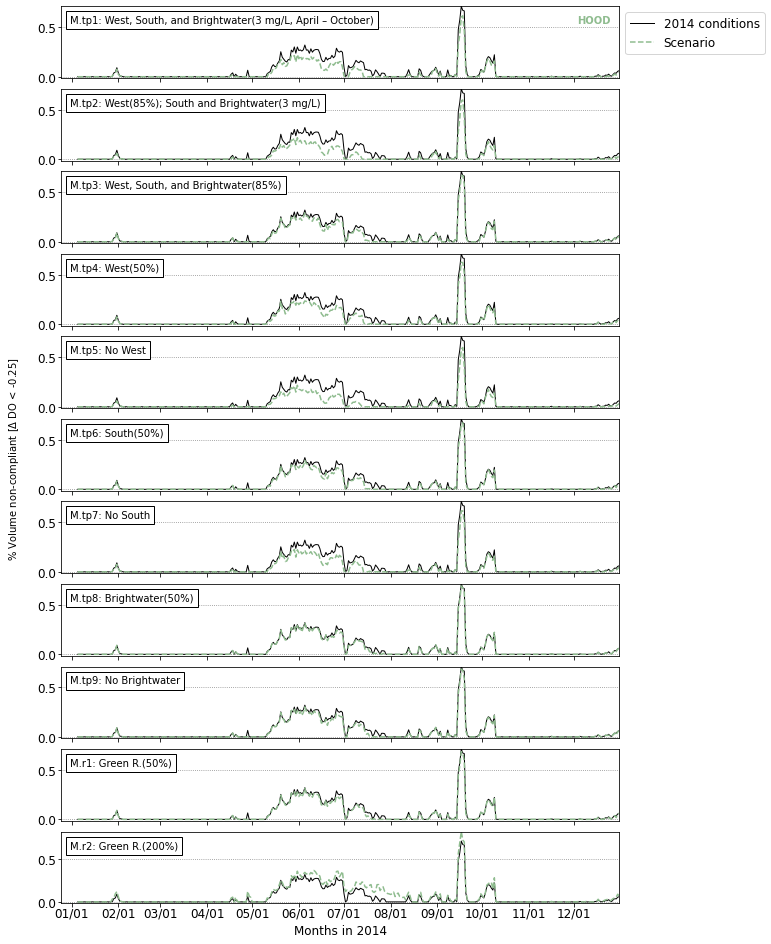

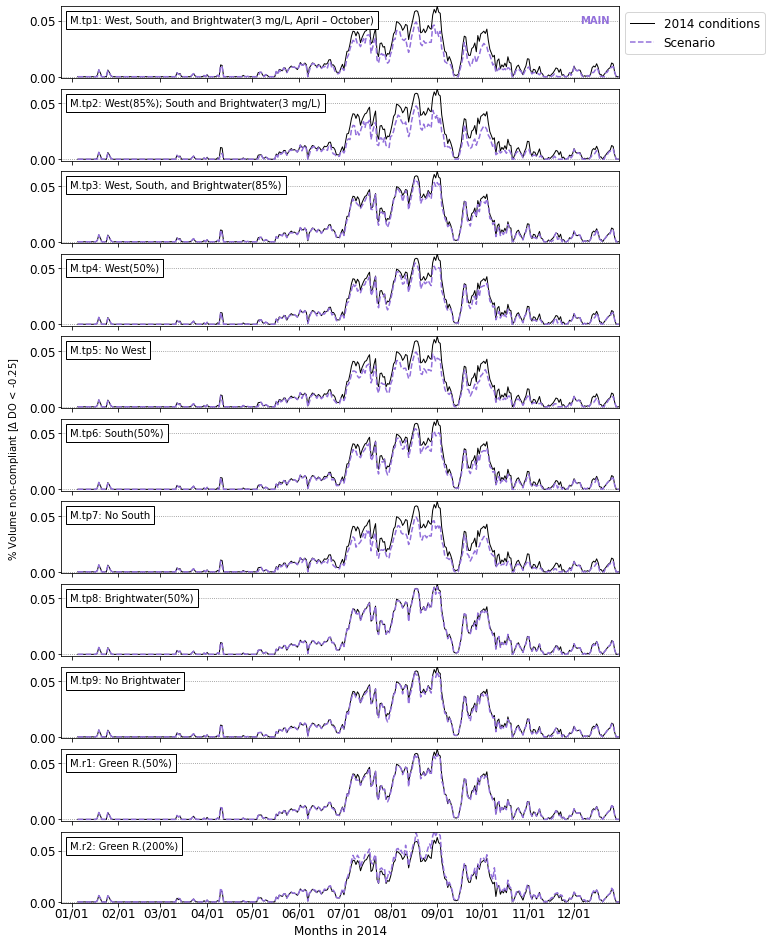

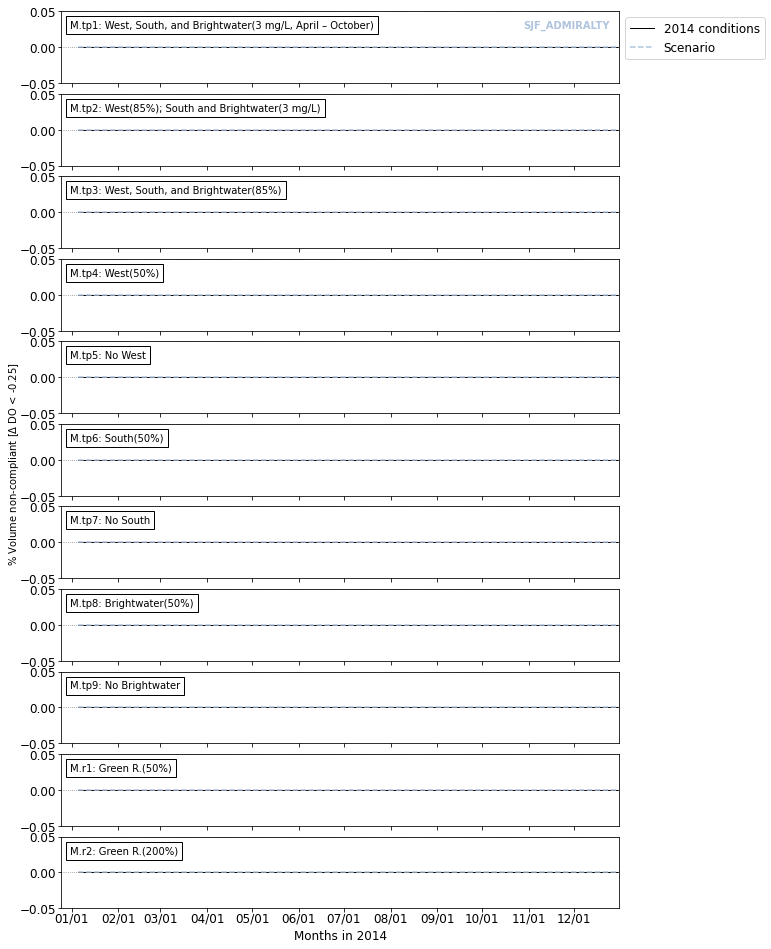

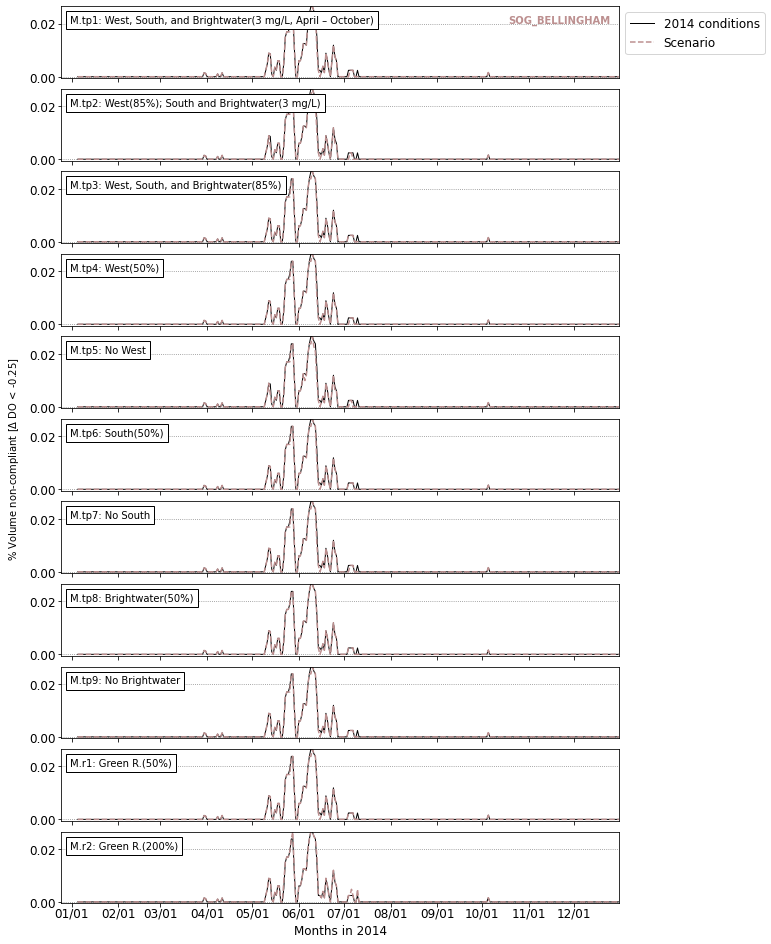

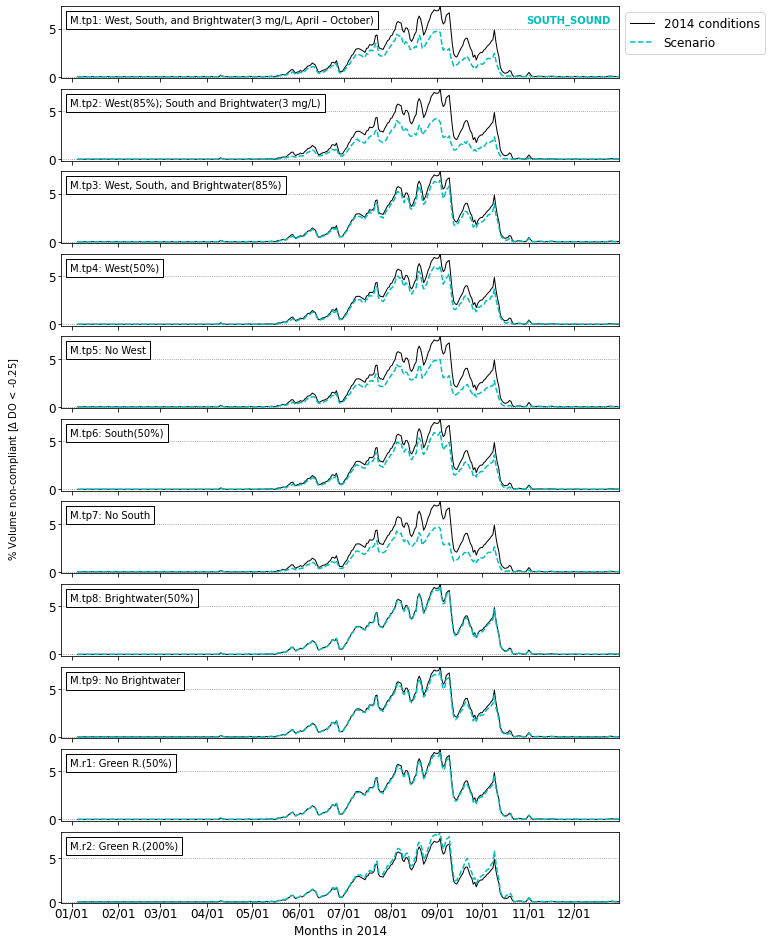

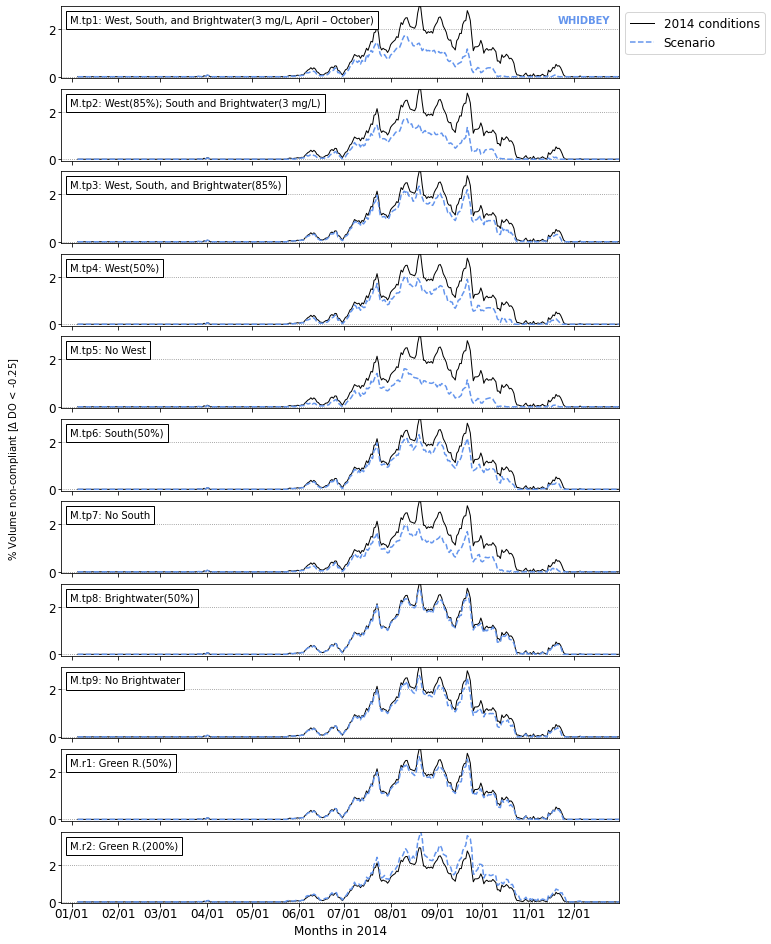

In [9]:
nfigs = 11
if case == 'main':
    for region in regions:
        print(region)
        fig, ax = plt.subplots(nrows=nfigs, ncols=1, figsize=(10, nfigs*6/4),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1]*nfigs,
                       'wspace': 0.25,
                       'hspace': 0.15})
        for idx,run in enumerate(plot_runs):
            # get the subplot indices from dictionary
            xa=axis_dict[plot_runs[idx]][1]
            ya=axis_dict[plot_runs[idx]][0]
            # plot results
            ax[ya].plot(
                ts_base_df['date'], 
                ts_base_df[region],
                color = ssm['bw_line']['color']['baseline'],
                lw = ssm['bw_line']['width']['baseline'],
                ls = ssm['bw_line']['style']['baseline'],
                label='2014 conditions'
            )
            
            #run = run.split('_')[1]
                
            if color:
                try: 
                    ax[ya].plot(
                        tsdf[run]['date'],
                        tsdf[run][region],
                        color=ssm['region']['colors'][region],
                        ls=ssm['bw_line']['style']['scenario'],
                        lw=ssm['bw_line']['width']['scenario'],
                        label=f'Scenario'           
                    )
                except:
                    #pass
                    continue
                    print(run, " not found")
                    
            else:
                ax[ya].plot(
                    tsdf[run]['date'],
                    tsdf[run][region],
                    color=ssm['bw_line']['color']['scenario'],
                    ls=ssm['bw_line']['style']['scenario'],
                    lw=ssm['bw_line']['width']['scenario'],
                    label=f'Scenario'
                )
            
            #run = f'M_{run}'
            
            ax[ya].grid(axis='y', color='grey',ls='dotted')
            # Add text with scenario information to upper left corner 
            anchored_text = AnchoredText(
                ssm['run_information']['run_description_short'][case][excel_tag_map[run]],
                loc='upper left',
                frameon=True,
                prop=dict(fontweight="normal",color="black")
            )
            ax[ya].add_artist(anchored_text) 
            
            #run = run.split('_')[1]
            
            
            # set the ylim to the maximum between scenario and baseline
            y_max = max(np.max(tsdf[run][region]), np.max(ts_base_df[region]))
            ax[ya].set_ylim(-2e-2*y_max, y_max)
            ax[ya].set_xlim(np.datetime64('2013-12-25'), np.datetime64('2014-12-31'))
            # set x-ticklabels to the 15th day of the month 
            ax[ya].xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=15))
            # set x-ticklabels to the first day of the month
            ax[ya].xaxis.set_major_locator(mpl.dates.MonthLocator())
            ax[ya].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d'))
            if (ya!=nruns-1):
                ax[ya].set_xticklabels('')
            # Add text showing region to upper right corner of first panel
            if ya==0:
                if color: 
                    anchored_text = AnchoredText(
                        region.upper(), 
                        loc='upper right',
                        frameon=False,
                        prop=dict(fontweight="bold",color=ssm['region']['colors'][region],ha="right")
                    )
                else: 
                    anchored_text = AnchoredText(
                        region.upper(), 
                        loc='upper right',
                        frameon=False,
                        prop=dict(fontweight="bold",color="black",ha="right")
                    )
                ax[ya].add_artist(anchored_text) 
        fig.text(0.05, 0.5, 
                 f'% Volume non-compliant [$\Delta$ DO < {noncompliant}]', 
                 va='center', rotation='vertical'
                )

        ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
        ax[nruns-1].set_xlabel('Months in 2014')

        if color:
            output_file = output_directory/f'{case}_{region}_noncompliant_{non_compliant_txt}_wc_TS'
        else:
            output_file = output_directory/f'{case}_{region}_noncompliant_{non_compliant_txt}_wc_TS_BW'
        print(f'saving {output_file}')
        plt.savefig(f'{output_file}.png', bbox_inches='tight', format='png', dpi=dpi_mag)
        plt.savefig(f'{output_file}.pdf', bbox_inches='tight', format='pdf', dpi=dpi_mag,orientation='portrait', papertype='letter')
        plt.show 

In [20]:
[*tsdf]

['Reference',
 'M.tp5',
 'M.tp2',
 'M.tp1',
 'M.r2',
 'M.tp3',
 'M.tp7',
 'M.tp8',
 'M.tp4',
 'M.tp9',
 'M.r1']

0.5274594147310501
0.33021140388565584
0.017607842277113983


IndexError: index 9 is out of bounds for axis 0 with size 3

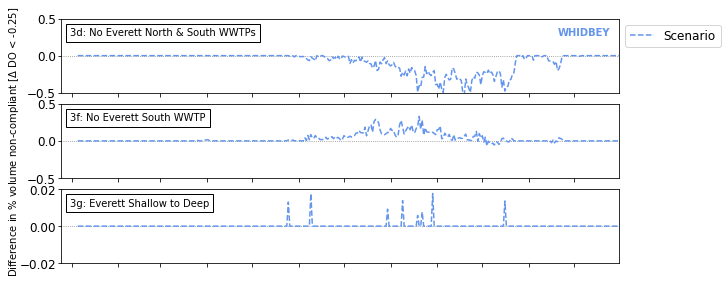

In [26]:
nfigs = 3
fig, ax = plt.subplots(nrows=nfigs, ncols=1, figsize=(10, nfigs*6/4),
               gridspec_kw={
                   'width_ratios': [1],
                   'height_ratios': [1,1,1],#np.ones([1,nfigs]),#[1,1,1,1,1,1,1,1,1,1],
               'wspace': 0.25,
               'hspace': 0.15})
region = 'Whidbey'
for idx,run in enumerate(['3d','3f','3g']): # compare with '3e': No Everette North
    print(max(abs(max(tsdf[run][region]-tsdf['3e'][region])), abs(min(tsdf[run][region]-tsdf['3e'][region]))))
    # get the subplot indices from dictionary
    xa=axis_dict[plot_runs[idx]][1]
    ya=axis_dict[plot_runs[idx]][0]
    # plot results
    if color:
         ax[ya].plot(
            tsdf[run]['date'],
            tsdf[run][region]-tsdf['3e'][region],
            color=ssm['region']['colors'][region],
            ls=ssm['bw_line']['style']['scenario'],
            lw=ssm['bw_line']['width']['scenario'],
            label=f'Scenario'           
        )
    else:
        ax[ya].plot(
            tsdf[run]['date'],
            tsdf[run][region]-tsdf['3e'][region],
            color=ssm['bw_line']['color']['scenario'],
            ls=ssm['bw_line']['style']['scenario'],
            lw=ssm['bw_line']['width']['scenario'],
            label=f'Scenario'
        )
    ax[ya].grid(axis='y', color='grey',ls='dotted')
    # Add text with scenario information to upper left corner 
    anchored_text = AnchoredText(
        ssm['run_information']['run_description_short'][case][excel_tag_map[run]],
        loc='upper left',
        frameon=True,
        prop=dict(fontweight="normal",color="black")
    )
    ax[ya].add_artist(anchored_text) 
    # set the ylim to the maximum between scenario and baseline
    y_max = max(np.max(tsdf[run][region]), np.max(ts_base_df[region]))
    ax[ya].set_ylim(-0.5, 0.5)
    if run == '3g':
        ax[ya].set_ylim(-0.02, 0.02)    
    ax[ya].set_xlim(np.datetime64('2013-12-25'), np.datetime64('2014-12-31'))
    # set x-ticklabels to the 15th day of the month 
    ax[ya].xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=15))
    # set x-ticklabels to the first day of the month
    ax[ya].xaxis.set_major_locator(mpl.dates.MonthLocator())
    ax[ya].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d'))
    if (ya!=nruns-1):
        ax[ya].set_xticklabels('')
    # Add text showing region to upper right corner of first panel
    if ya==0:
        if color: 
            anchored_text = AnchoredText(
                region.upper(), 
                loc='upper right',
                frameon=False,
                prop=dict(fontweight="bold",color=ssm['region']['colors'][region],ha="right")
            )
        else: 
            anchored_text = AnchoredText(
                region.upper(), 
                loc='upper right',
                frameon=False,
                prop=dict(fontweight="bold",color="black",ha="right")
            )
        ax[ya].add_artist(anchored_text) 
fig.text(0.05, 0.5, 
         f'Difference in % volume non-compliant [$\Delta$ DO < {noncompliant}]', 
         va='center', rotation='vertical'
        )

ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
ax[nruns-1].set_xlabel('Months in 2014')

# if color:
#     output_file = output_directory/f'{case}_{region}_noncompliant_{non_compliant_txt}_wc_TS'
# else:
#     output_file = output_directory/f'{case}_{region}_noncompliant_{non_compliant_txt}_wc_TS_BW'
# print(f'saving {output_file}')
# plt.savefig(f'{output_file}.png', bbox_inches='tight', format='png', dpi=dpi_mag)
# plt.savefig(f'{output_file}.pdf', bbox_inches='tight', format='pdf', dpi=dpi_mag,orientation='portrait', papertype='letter')
# plt.show